<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/1212_5000_random_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Example random network with 5000 nodes**

In this part of the project, we create a tool to achieve the following:
1. Our input is an N by N matrix representing a social network with N nodes with 1 or 0 representing the presence or absence of edges.
2. We then construct a graph from the given matrix.
3. Based on the network, we apply the equations for individual infection risk, derive the corresponding equations, and compute a table of probability with infection starting at different nodes.
4. Finally, we take the average infection probability of each node, excluding the case when it is the seed.
5. Depending on the average infection probabilty, we color the network graph with a heatmap color scheme, such that red is the highest infection risk and blue/purple is the lowest infection risk.
6. Our output include: a probability table, a table including all the average infection probability, and a heatmap network for individual infection probability/risk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp
import math

In [ ]:
# Function to generate a random N by N adjacency matrix representing a network without self-loop give number of nodes N
def generate_random_network(N, p=0.3):
    adj_matrix = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if i != j:
                adj_matrix[i][j] = 1 if random.random() < p else 0
    return adj_matrix

In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def preprocess_neighbors(G):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []

    for v in nodes:
        neighs = list(G.neighbors(v))
        neighbors_idx.append(np.array([node_index[u] for u in neighs], dtype=int))

    return nodes, node_index, neighbors_idx

In [ ]:
def fixed_point_solver_message_passing(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=5000, relax=0.3):

    n = len(neighbors_idx)

    edge_to_idx = {}
    idx_to_edge = []

    for i in range(n):
        for j in neighbors_idx[i]:
            edge_to_idx[(j, i)] = len(idx_to_edge)
            idx_to_edge.append((j, i))

    m = len(idx_to_edge)

    # Messages theta_{j->i}: probability that j does NOT infect i
    theta = np.ones(m, dtype=float)

    for _ in range(max_iter):
        theta_new = theta.copy()

        for e_idx, (j, i) in enumerate(idx_to_edge):
            if j == seed_index:
                theta_new[e_idx] = 1.0 - p_val
                continue

            neigh_j = neighbors_idx[j]

            # Compute u_{j->i} = product over k in N(j)\{i} of theta_{k->j}
            if len(neigh_j) == 0:
                u = 1.0
            else:
                prod = 1.0
                for k in neigh_j:
                    if k == i:
                        continue
                    prod *= theta[edge_to_idx[(k, j)]]
                u = prod

            theta_new[e_idx] = 1.0 - p_val + p_val * u

        theta_updated = (1.0 - relax) * theta + relax * theta_new

        if np.max(np.abs(theta_updated - theta)) < tol:
            theta = theta_updated
            break

        theta = theta_updated

    sigma = np.zeros(n, dtype=float)

    for i in range(n):
        if i == seed_index:
            sigma[i] = 1.0
            continue

        neigh_i = neighbors_idx[i]
        if len(neigh_i) == 0:
            sigma[i] = 0.0
            continue

        prod = 1.0
        for j in neigh_i:
            prod *= theta[edge_to_idx[(j, i)]]
        sigma[i] = 1.0 - prod

    return sigma

In [ ]:
def prepare_mp(neighbors_idx):
    n = len(neighbors_idx)

    sender = []
    receiver = []
    edge_to_idx = {}

    for i in range(n):
        for j in neighbors_idx[i]:
            edge_to_idx[(j, i)] = len(sender)
            sender.append(j)
            receiver.append(i)

    sender = np.asarray(sender, dtype=np.int32)
    receiver = np.asarray(receiver, dtype=np.int32)
    m = sender.size

    rev = np.empty(m, dtype=np.int32)
    for e in range(m):
        rev[e] = edge_to_idx[(receiver[e], sender[e])]

    out_edges = [[] for _ in range(n)]
    for e in range(m):
        out_edges[sender[e]].append(e)
    out_edges = [np.asarray(x, dtype=np.int32) for x in out_edges]

    return {
        "n": n,
        "m": m,
        "sender": sender,
        "receiver": receiver,
        "rev": rev,
        "out_edges": out_edges,
    }

In [ ]:
def fixed_point_solver_message_passing_fast(prep, seed_index, p_val,
                                            tol=1e-6, max_iter=5000, relax=0.3):

    n = prep["n"]
    sender = prep["sender"]
    receiver = prep["receiver"]
    rev = prep["rev"]
    out_edges = prep["out_edges"]

    theta = np.ones(prep["m"], dtype=float)

    if out_edges[seed_index].size:
        theta[out_edges[seed_index]] = 1.0 - p_val

    for _ in range(max_iter):
        P = np.ones(n)
        np.multiply.at(P, receiver, theta)

        u = P[sender] / theta[rev]
        theta_new = 1.0 - p_val + p_val * u

        if out_edges[seed_index].size:
            theta_new[out_edges[seed_index]] = 1.0 - p_val

        theta_updated = (1.0 - relax) * theta + relax * theta_new

        if np.max(np.abs(theta_updated - theta)) < tol:
            theta = theta_updated
            break

        theta = theta_updated

    P = np.ones(n)
    np.multiply.at(P, receiver, theta)

    sigma = 1.0 - P
    sigma[seed_index] = 1.0
    return sigma

In [ ]:
from joblib import Parallel, delayed

def compute_attack_matrix(G, p_val, n_jobs=-1):
    nodes, node_index, neighbors_idx = preprocess_neighbors(G)
    n = len(nodes)

    prep = prepare_mp(neighbors_idx)

    sigmas = Parallel(n_jobs=n_jobs)(
        delayed(fixed_point_solver_message_passing_fast)(
            prep, seed_index=node_index[s], p_val=p_val
        )
        for s in nodes
    )

    mat = np.array(sigmas).T
    return nodes, mat

def save_attack_csv(nodes, mat, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_5000_p{p_val:.3f}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average_5000_p{p_val:.3f}.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df

In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network_scirep(
    G,
    nodes,
    avg_attack,
    cmap_name="jet",
    out_path="/content/drive/My Drive/Individual_Attack_Rate/individual_attack_network_5000_random.pdf"
):
    nodes = list(nodes)
    avg_attack = np.asarray(avg_attack, dtype=float)
    attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}
    pos = nx.spring_layout(G, seed=42, k=0.25, iterations=300)
    node_colors = [attack_dict[n] for n in G.nodes()]
    vmin = float(np.nanmin(avg_attack))
    vmax = float(np.nanmax(avg_attack))
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.set_facecolor("white")
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.8, width=1.0, edge_color="gray")
    nodes_draw = nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_color=node_colors,
        cmap=plt.get_cmap(cmap_name),
        node_size=40,
        linewidths=0.4,
        edgecolors="black",
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(nodes_draw, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)
    cbar.set_label("Average individual infection probability", fontsize=10)
    cbar.ax.tick_params(labelsize=10)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    plt.show()

In [ ]:
N = 5000
target_k = 12
q = target_k / (N - 1)
adj_matrix = generate_random_network(N, q)
p = 0.1
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_5000.pkl", "wb") as f:
    pickle.dump(adj_matrix, f)
G = generate_network(adj_matrix)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_5000.pkl", "wb") as f:
    pickle.dump(G, f)
nodes, mat = compute_attack_matrix(G, p)
path, df = save_attack_csv(nodes, mat, p)
avg_attack = compute_average_attack(nodes, mat)
path2,df2 = save_average_attack_csv(nodes, avg_attack, p)

In [ ]:
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_5000.pkl", "rb") as f:
    adj_matrix = pickle.load(f)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_5000.pkl", "rb") as f:
    G_loaded = pickle.load(f)

In [ ]:
import pandas as pd
import os

def save_graph_neighbor_csv(G, filename="graph_neighbors_5000.csv"):
    outdir = "/content/drive/My Drive/Individual_Attack_Rate"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
path3, df3 = save_graph_neighbor_csv(G, "G_neighbors_5000.csv")
print("Saved to:", path3)

Saved to: /content/drive/My Drive/Individual_Attack_Rate/G_neighbors_5000.csv


In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    df = pd.read_csv(csv_path)
    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    df_ranked["Rank"] = df_ranked.index + 1

    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_5000_random.csv")
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
csv_path = "/content/drive/My Drive/Individual_Attack_Rate/average_5000_p0.100.csv"

out_path, df_ranked = rank_nodes_by_attack(csv_path)
print("Saved ranked file to:", out_path)


Ranked results:

   Node  AverageAttackRate  Rank
0  2401           0.562228     1
1  2520           0.557482     2
2   343           0.553028     3
3  3224           0.549318     4
4  3372           0.539150     5
Saved ranked file to: /content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random.csv


In [ ]:
# Load the CSV
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/Individual_Attack_Rate/G_neighbors_5000.csv")

# Take 5 random rows (or head())
sample = df.sample(5)

# Convert to LaTeX
latex_table = sample.to_latex(
    index=False,
    column_format="lll",
    caption="Sample rows from the node–neighbor–degree table.",
    label="tab:sample_neighbors",
    escape=False
)

print(latex_table)

\begin{table}
\caption{Sample rows from the node–neighbor–degree table.}
\label{tab:sample_neighbors}
\begin{tabular}{lll}
\toprule
node & neighbors & degree \\
\midrule
4922 & 253,510,599,1222,1480,1702,2041,2354,2755,3029,3372,3396,3842,4050,4766 & 15 \\
155 & 160,210,316,891,1136,1501,1939,3137,3621,4306,4838 & 11 \\
569 & 231,838,2057,2275,2552,2596,3086,3173,4339,4387 & 10 \\
1110 & 670,740,999,1195,1232,1911,2846,3019,3993,4526,4528,4659,4783,4933,4971,4989 & 16 \\
978 & 1498,1667,1878,2461,2756,2805,2900,3242,3376,4847 & 10 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
import pandas as pd

ranked_path = "/content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random.csv"
df_ranked = pd.read_csv(ranked_path)

top5 = df_ranked.head(5)
bottom5 = df_ranked.tail(5)

top5_latex = top5.to_latex(
    index=False,
    column_format="lll",
    caption="Top 5 nodes with highest average infection probability.",
    label="tab:top5_attack",
    float_format="%.6f"
)

bottom5_latex = bottom5.to_latex(
    index=False,
    column_format="lll",
    caption="Bottom 5 nodes with lowest average infection probability.",
    label="tab:bottom5_attack",
    float_format="%.6f"
)

print("\n===== TOP 5 (LaTeX) =====\n")
print(top5_latex)

print("\n===== BOTTOM 5 (LaTeX) =====\n")
print(bottom5_latex)


===== TOP 5 (LaTeX) =====

\begin{table}
\caption{Top 5 nodes with highest average infection probability.}
\label{tab:top5_attack}
\begin{tabular}{lll}
\toprule
Node & AverageAttackRate & Rank \\
\midrule
2401 & 0.562228 & 1 \\
2520 & 0.557482 & 2 \\
343 & 0.553028 & 3 \\
3224 & 0.549318 & 4 \\
3372 & 0.539150 & 5 \\
\bottomrule
\end{tabular}
\end{table}


===== BOTTOM 5 (LaTeX) =====

\begin{table}
\caption{Bottom 5 nodes with lowest average infection probability.}
\label{tab:bottom5_attack}
\begin{tabular}{lll}
\toprule
Node & AverageAttackRate & Rank \\
\midrule
2649 & 0.078358 & 4996 \\
296 & 0.065238 & 4997 \\
4163 & 0.064601 & 4998 \\
1659 & 0.064009 & 4999 \\
2953 & 0.061220 & 5000 \\
\bottomrule
\end{tabular}
\end{table}



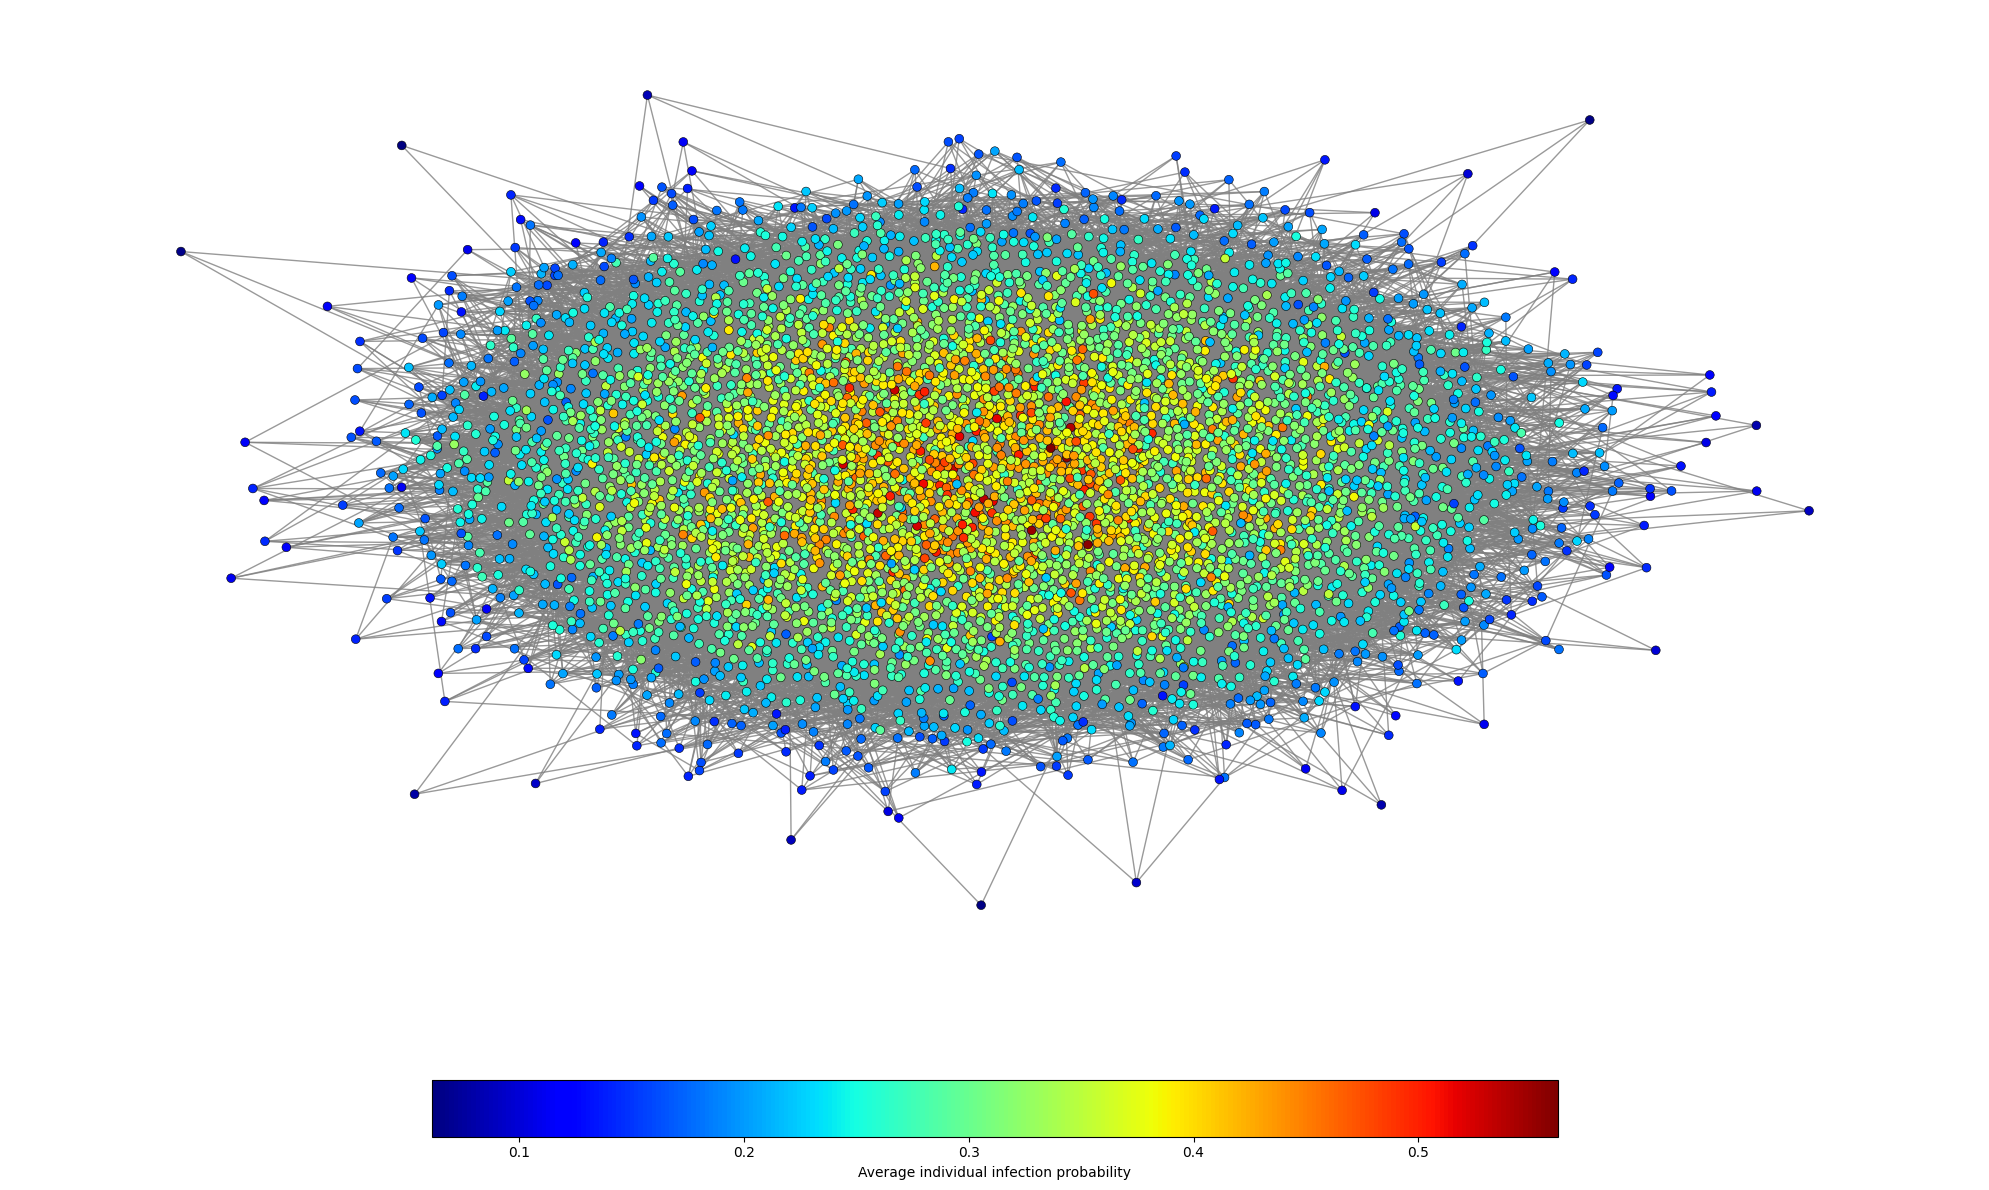

In [ ]:
visualize_attack_network_scirep(G, nodes, avg_attack)

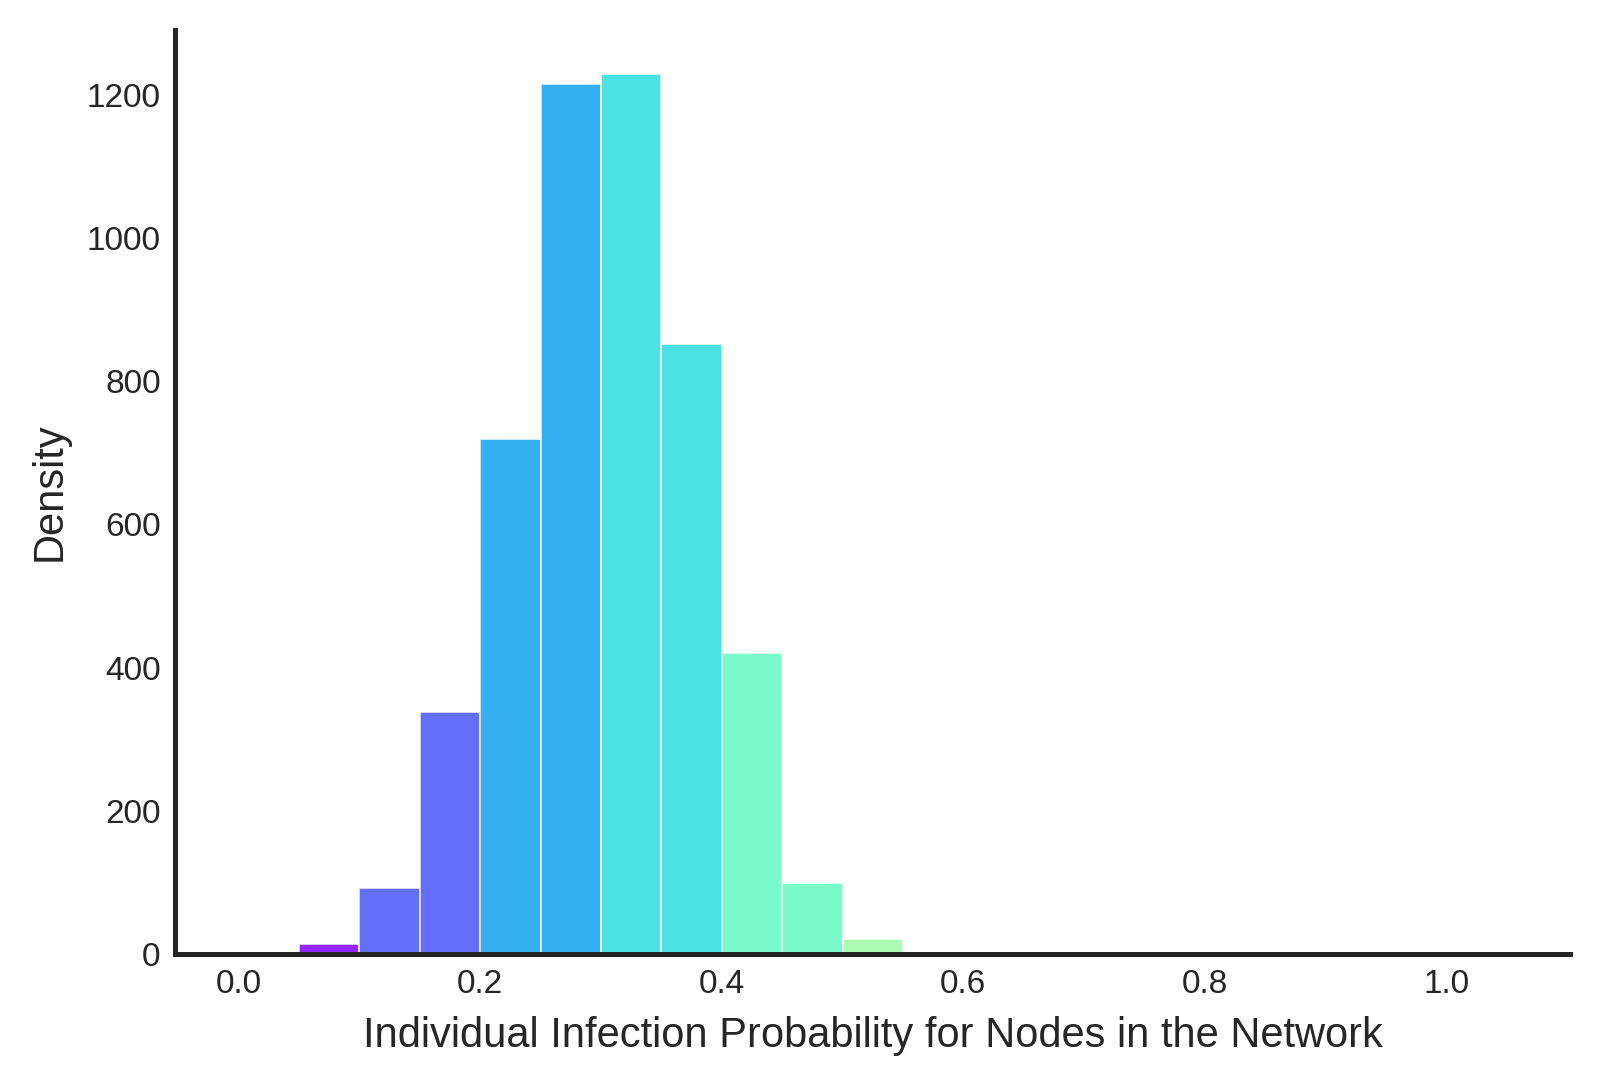

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ranked_path = "/content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random.csv"
df_ranked = pd.read_csv(ranked_path)

vals = df_ranked["AverageAttackRate"].values
vals = vals[~np.isnan(vals)]

plt.style.use("seaborn-v0_8-white")

main_bins = np.arange(0, 1.1, 0.1)
hist_bins = np.arange(0, 1.05 + 0.001, 0.05)   # bin width = 0.05

colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))

plt.figure(figsize=(6, 4), dpi=300)

for i in range(len(main_bins)-1):
    lo, hi = main_bins[i], main_bins[i+1]
    mask = (vals >= lo) & (vals < hi)
    plt.hist(
        vals[mask],
        bins=hist_bins,
        alpha=0.85,
        color=colors[i],
        edgecolor="white",
        linewidth=0.4
    )

plt.xlabel("Individual Infection Probability for Nodes in the Network", fontsize=10)
plt.ylabel("Density", fontsize=10)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

plt.savefig("/content/drive/My Drive/Individual_Attack_Rate/histogram_5000.pdf", bbox_inches="tight")
plt.show()

In [ ]:
neighbors_path = "/content/drive/My Drive/Individual_Attack_Rate/G_neighbors_5000.csv"
ranked_path    = "/content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random.csv"

outdir = os.path.dirname(ranked_path)
out_path = os.path.join(outdir, "ranked_5000_random_centrality.csv")

df_neighbors = pd.read_csv(neighbors_path)   # has: node, neighbors, degree
df_ranked    = pd.read_csv(ranked_path)      # has: Node, AverageAttackRate, Rank

G = nx.Graph()
for _, row in df_neighbors.iterrows():
    i = int(row["node"])
    neighs = [
        int(x) for x in str(row["neighbors"]).split(",")
        if str(x).strip() != ""
    ]
    for j in neighs:
        G.add_edge(i, j)

deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G, normalized=True)

centrality_df = pd.DataFrame({
    "node": list(deg_cent.keys()),
    "degree_centrality": [deg_cent[n] for n in deg_cent],
    "betweenness_centrality": [bet_cent[n] for n in deg_cent],
})

df_ranked["node"] = df_ranked["Node"]  # create a common key
merged = df_ranked.merge(centrality_df, on="node", how="left")
merged = merged.drop(columns=["node"])

merged.to_csv(out_path, index=False)
print("Saved merged file with centralities to:", out_path)
print(merged.head())


Saved merged file with centralities to: /content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random_centrality.csv
   Node  AverageAttackRate  Rank  degree_centrality  betweenness_centrality
0  2401           0.562228     1           0.004801                0.002147
1  2520           0.557482     2           0.004801                0.001972
2   343           0.553028     3           0.005001                0.002298
3  3224           0.549318     4           0.004801                0.002166
4  3372           0.539150     5           0.004601                0.001796


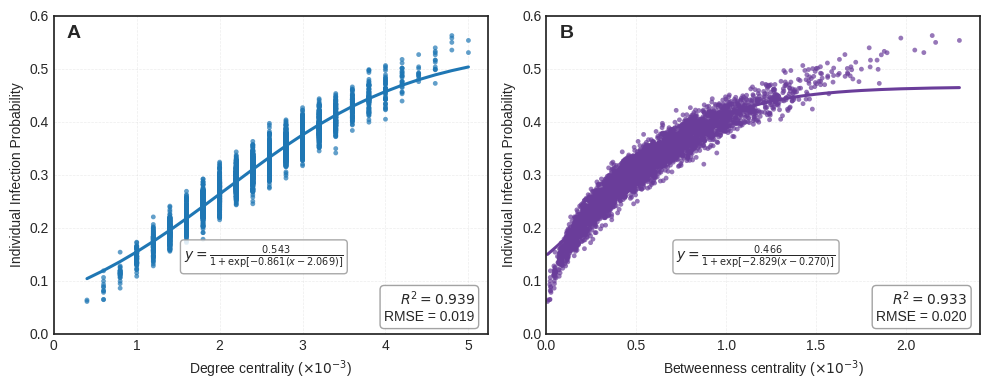

Degree: $y = \frac{0.543}{1 + \exp[-0.861(x_\mathrm{scaled} - 2.069)]}$
Between: $y = \frac{0.466}{1 + \exp[-2.829(x_\mathrm{scaled} - 0.270)]}$


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

in_path = "/content/drive/My Drive/Individual_Attack_Rate/ranked_5000_random_centrality.csv"
outdir  = os.path.dirname(in_path)
fig_path = os.path.join(outdir, "centrality_vs_infection_probability_5000.pdf")

df = pd.read_csv(in_path)

y = df["AverageAttackRate"].values

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def plot_saturating(ax, x_raw, y, xlabel, panel_label, color):
    x_scaled = x_raw.values * 1e3
    x = x_scaled

    p0 = [1.0, 1.0, np.median(x)]

    params, _ = curve_fit(logistic, x, y, p0=p0, maxfev=20000)
    L, k, x0 = params

    y_pred = logistic(x, L, k, x0)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    order = np.argsort(x)
    xs = x[order]
    ys = y[order]
    yfit = y_pred[order]

    # scatter + logistic fit
    ax.scatter(xs, ys, s=12, alpha=0.7, color=color, edgecolor="none")
    ax.plot(xs, yfit, lw=2.2, color=color)

    ax.set_xlabel(f"{xlabel} ($\\times 10^{{-3}}$)")
    ax.set_ylabel("Individual Infection Probability")

    ax.text(0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=14, fontweight="bold")

    # stats box
    ax.text(0.97, 0.03,
            f"$R^2 = {r2:.3f}$\nRMSE = {rmse:.3f}",
            transform=ax.transAxes,
            ha="right", va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3",
                      fc="white", ec="0.6", alpha=0.9))

    ax.tick_params(direction="in", top=True, right=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)
    ax.set_xlim(left=0)
    ax.set_ylim(0, 0.6)

    formula_text = (
    r"$y = \frac{{{:.3f}}}{{1 + \exp[-{:.3f}(x - {:.3f})]}}$"
    .format(L, k, x0))

    ax.text(
        0.30, 0.20,
        formula_text,
        transform=ax.transAxes,
        fontsize=10,
        ha="left", va="bottom",
        bbox=dict(
            boxstyle="round,pad=0.25",
            fc="white",
            ec="0.6",
            alpha=0.85
        )
    )

    return L, k, x0, r2, rmse

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

L_deg, k_deg, x0_deg, r2_deg, rmse_deg = plot_saturating(
    axes[0],
    df["degree_centrality"],
    y,
    xlabel="Degree centrality",
    panel_label="A",
    color="#1f77b4"
)

L_bet, k_bet, x0_bet, r2_bet, rmse_bet = plot_saturating(
    axes[1],
    df["betweenness_centrality"],
    y,
    xlabel="Betweenness centrality",
    panel_label="B",
    color="#6a3d9a"
)

for ax in axes:
    ax.set_ylim(0, 0.6)
    ax.set_xlim(left=0)

fig.tight_layout()
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.show()

print(
    fr"Degree: $y = \frac{{{L_deg:.3f}}}{{1 + \exp[-{k_deg:.3f}(x_\mathrm{{scaled}} - {x0_deg:.3f})]}}$"
)
print(
    fr"Between: $y = \frac{{{L_bet:.3f}}}{{1 + \exp[-{k_bet:.3f}(x_\mathrm{{scaled}} - {x0_bet:.3f})]}}$"
)


In [ ]:
# Histogram for distribution of probability for a node of a certain degree
def plot_prob_histograms_by_degree(individual_csv,
                                   neighbors_csv,
                                   bins=np.linspace(0, 1, 21),
                                   max_cols=6,
                                   save_pdf=True,
                                   outname="histograms_by_degree_5000_random.pdf"):

    df_indiv = pd.read_csv(individual_csv)
    df_deg   = pd.read_csv(neighbors_csv)

    prob_cols = [c for c in df_indiv.columns if c.startswith("Seed ")]
    probs = df_indiv[prob_cols].to_numpy()

    np.fill_diagonal(probs, np.nan)

    N = probs.shape[0]
    deg_series = df_deg.set_index("node")["degree"].reindex(np.arange(N))

    unique_degrees = np.sort(deg_series.unique())
    n_deg = len(unique_degrees)

    n_cols = min(max_cols, n_deg)
    n_rows = math.ceil(n_deg / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 3.2 * n_rows),
                             sharex=True, sharey=True)

    if n_deg == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, k in enumerate(unique_degrees):
        ax = axes[idx]
        nodes_k = np.where(deg_series.values == k)[0]
        data_k = probs[nodes_k, :].ravel() # get all the probabilities for these rows
        data_k = data_k[~np.isnan(data_k)]

        if len(data_k) > 0:
            weights = np.ones_like(data_k) * 100.0 / len(data_k)
            ax.hist(data_k, bins=bins, weights=weights, edgecolor="black")

        ax.set_title(f"Degree k={k} (n={len(nodes_k)})")

        row = idx // n_cols
        col = idx % n_cols

        if row == n_rows - 1:
            ax.set_xlabel("Probability")
        else:
            ax.set_xlabel("")

        if col == 0:
            ax.set_ylabel("Frequency (%)")
        else:
            ax.set_ylabel("")

    for j in range(n_deg, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_pdf:
        outdir = os.path.dirname(individual_csv)
        outfile = os.path.join(outdir, outname)
        plt.savefig(outfile, format="pdf", dpi=300, bbox_inches="tight")
        print("Saved PDF to:", outfile)

    plt.show()

Saved PDF to: /content/drive/My Drive/Individual_Attack_Rate/degree_hist_panels_5000_nodes_p0.100.pdf


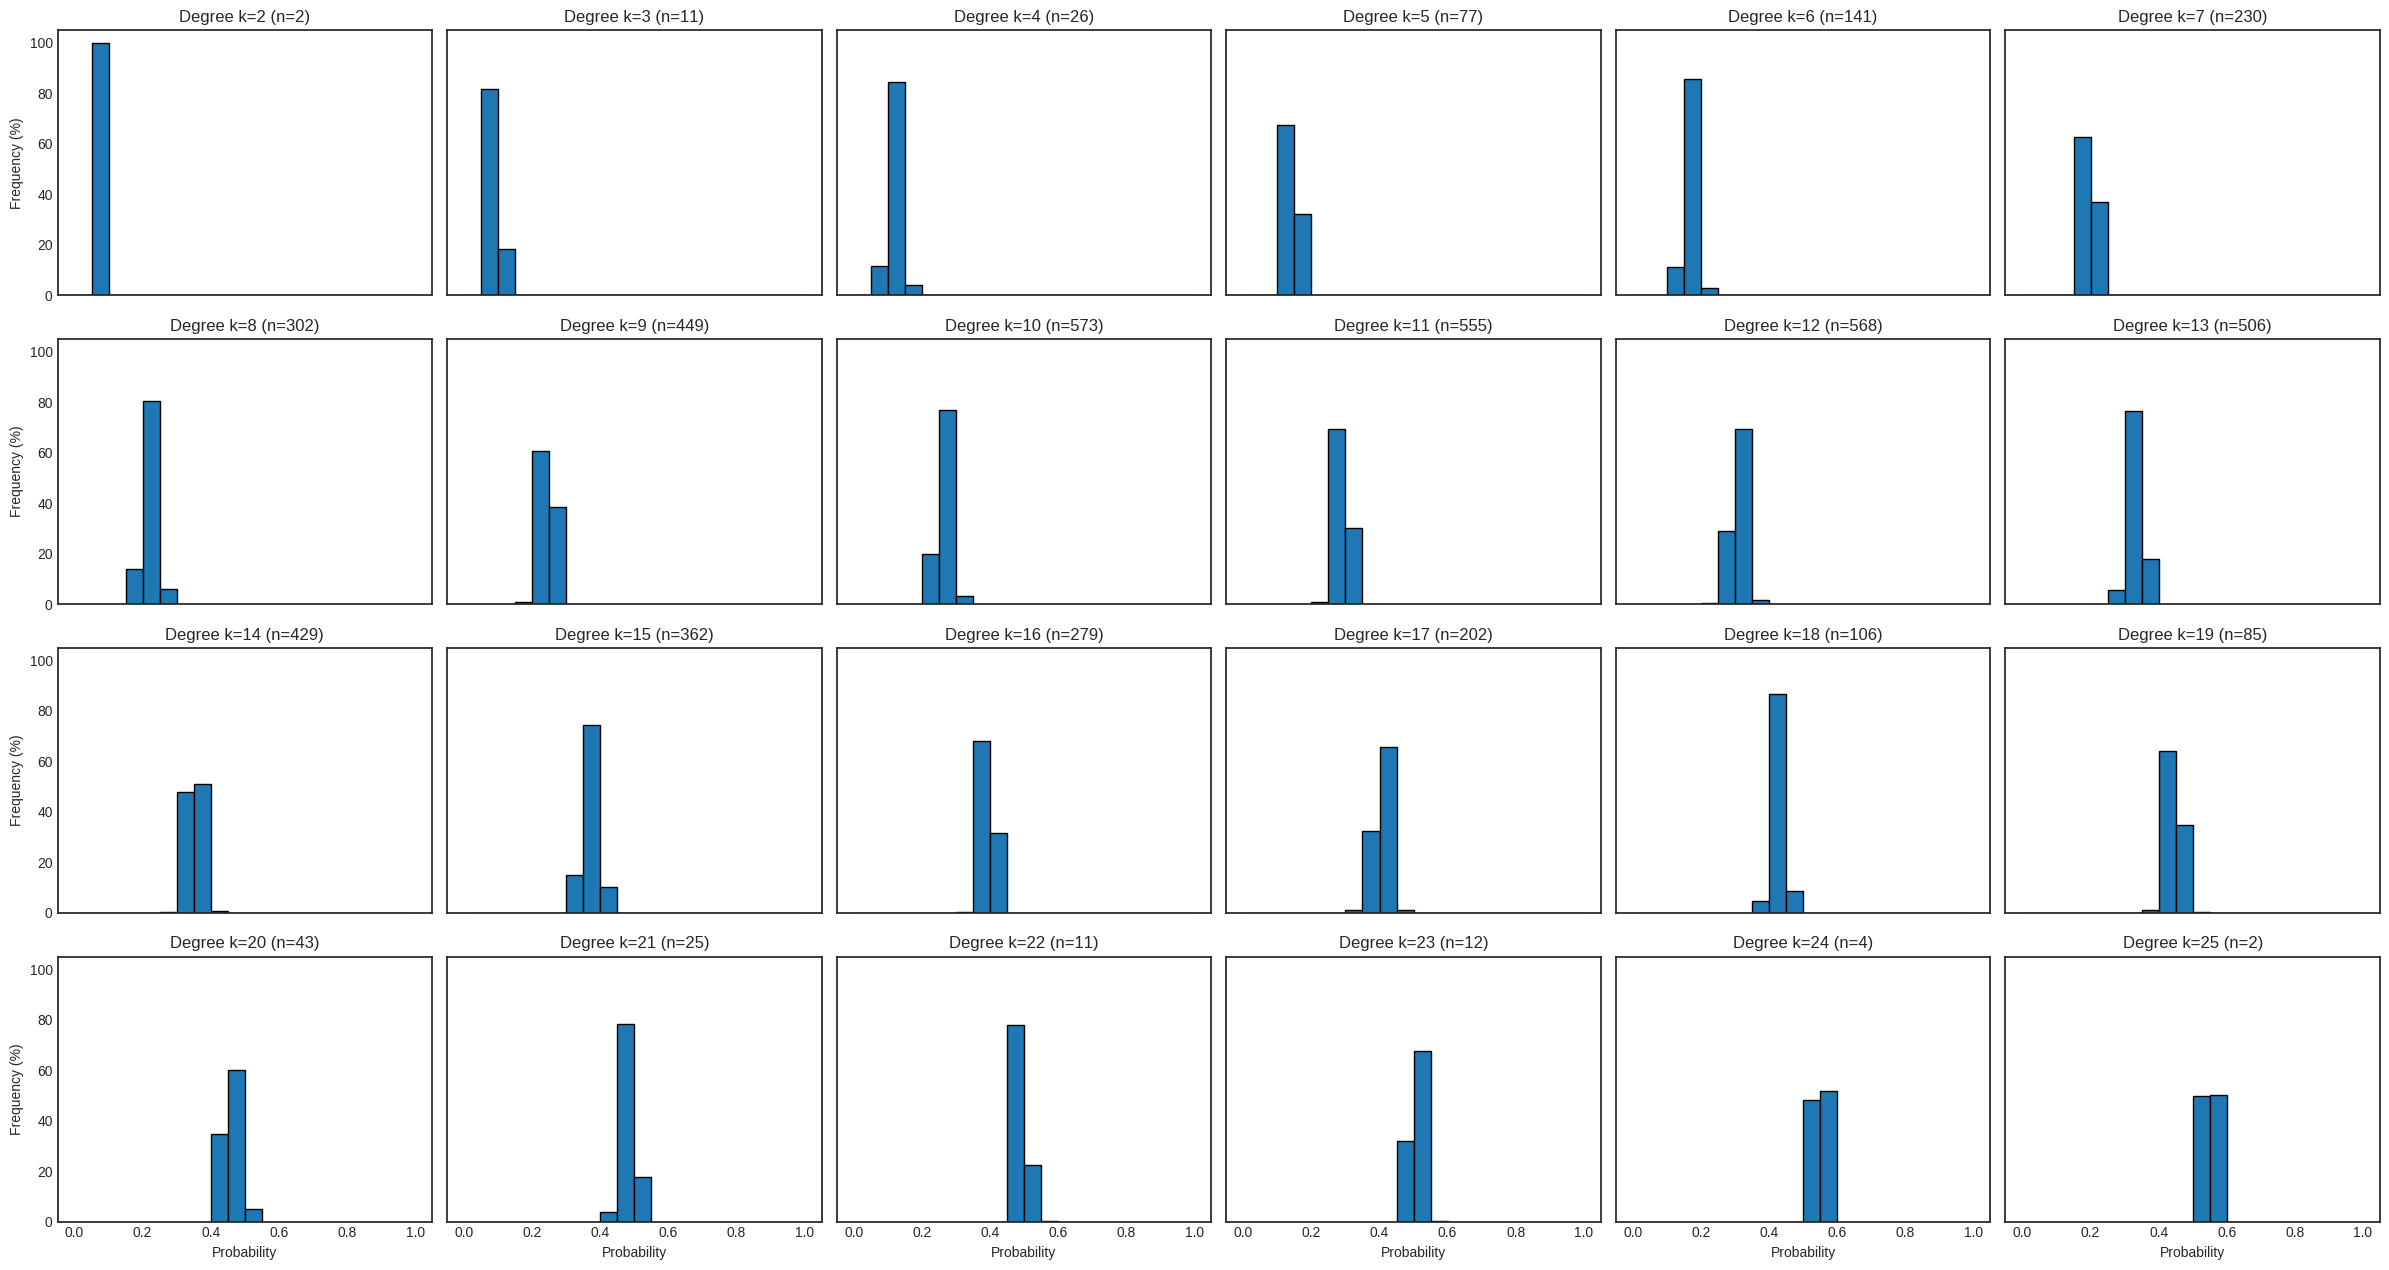

In [ ]:
individual_csv = "/content/drive/My Drive/Individual_Attack_Rate/individual_5000_p0.100.csv"
neighbors_csv  = "/content/drive/My Drive/Individual_Attack_Rate/G_neighbors_5000.csv"

plot_prob_histograms_by_degree(
    individual_csv,
    neighbors_csv,
    outname="degree_hist_panels_5000_nodes_p0.100.pdf"
)